# White blood cell classifier

Concept:

Build a model that can classify different types of white blood cells through images.

Rationale: Successful classification of cells leads to a more efficient way of doing manual differentials

Feasibility: A basic model can be built within a weekend using readily available Python libraries.

Relevance: AI Classification is used in analyzers that are able to review stained blood slides. This advanced technology in healthcare lessens the workload of the lab tech who must review each abnormal slide and count the cells manually.

Data-centric: This application relies heavily on large datasets of white blood cells in order to be trained to identify them confidently.

# 2.  Setup and Imports

First, we need to Install and  import the necessary libraries. Each library serves a specific purpose  

In [ ]:
# Install minimal required packages (run once)
# In some environments, you may already have these packages installed.
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', DEVICE)


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
True
11.8
1
Using device: cuda


# 3. Data Preparation



In [ ]:
# Unzip uploaded Raabin dataset and inspect structure
ZIP_PATH = Path('/mnt/data/raabin_wbc.zip')
EXTRACT_DIR = Path('raabin_raw')

if not EXTRACT_DIR.exists():
    print('Extracting', ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
else:
    print('Already extracted to', EXTRACT_DIR)

# List top-level dirs
top = [p for p in EXTRACT_DIR.iterdir() if p.is_dir()]
print('Top-level folders:', [p.name for p in top])

# Count images in Train/TestA/TestB-like folders
image_exts = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp')
counts = {}
for name in ['Train','train','TestA','TestB','test','testA','testB']:
    p = EXTRACT_DIR / name
    if p.exists():
        imgs = list(p.rglob('*'))
        img_count = sum(1 for f in imgs if f.is_file() and f.suffix.lower() in image_exts)
        counts[name] = img_count
print('Image counts (possible splits):', counts)

# Show a few sample image paths
samples = []
for p in EXTRACT_DIR.rglob('*'):
    if p.is_file() and p.suffix.lower() in image_exts:
        samples.append(str(p)[:200])
        if len(samples) >= 10: break
print('Sample images (first 10):')
for s in samples: print(' -', s)


Already extracted to raabin_raw
Top-level folders: ['TestA', 'TestB', 'Train']
Image counts (possible splits): {'Train': 10175, 'train': 10175, 'TestA': 4339, 'TestB': 2119, 'testA': 4339, 'testB': 2119}
Sample images (first 10):
 - raabin_raw\TestA\TestA\Basophil\20190526_163027_0.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163055_0.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163055_1.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163055_2.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163545_0.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163656_0.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163835_0.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_163835_1.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_164040_0.jpg
 - raabin_raw\TestA\TestA\Basophil\20190526_164638_0.jpg


#3.1 Splitting data
Before training the model, we will seperate the images into training and validation sets. It will help to see how well the model can identify new images of these cells.

The training set will be a larger set of data vs the validation set. The validation set is not used in training and will be used for evaluation of the model's performance. This will test to see if the model learns general patterns instead of memorizing the images.

In [ ]:
# Create standardized split directories: train/ val/ test based on Train / TestA / TestB in archive.
DATA_DIR = Path('wbc_raabin_split')
if DATA_DIR.exists():
    print('Data dir already exists:', DATA_DIR)
else:
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# Map archive folders to our splits (prefer exact names found in the archive)
archive_train = None
archive_val = None
archive_test = None

# Prefer 'Train' for training, 'TestA' for val, 'TestB' for test
if (EXTRACT_DIR / 'Train').exists():
    archive_train = EXTRACT_DIR / 'Train'
if (EXTRACT_DIR / 'TestA').exists():
    archive_val = EXTRACT_DIR / 'TestA'
if (EXTRACT_DIR / 'TestB').exists():
    archive_test = EXTRACT_DIR / 'TestB'

# Fallbacks: if TestA/TestB not present, we'll split Train folder
if archive_train is None:
    # find any folder with many images and use it
    candidates = [p for p in EXTRACT_DIR.iterdir() if p.is_dir()]
    candidates = sorted(candidates, key=lambda p: -sum(1 for f in p.rglob('*') if f.is_file() and f.suffix.lower() in ['.jpg','.png']))
    if candidates:
        archive_train = candidates[0]

print('Archive folders used -> train:', archive_train, 'val:', archive_val, 'test:', archive_test)

# Helper to copy class subfolders into our DATA_DIR/split/<classname>/
def copy_archive_to_split(archive_root: Path, split_name: str):
    if archive_root is None:
        return
    for class_dir in sorted([p for p in archive_root.iterdir() if p.is_dir()]):
        target_dir = DATA_DIR / split_name / class_dir.name
        target_dir.mkdir(parents=True, exist_ok=True)
        # copy images from possibly nested structure (some archives have Train/Train/Class/*.jpg)
        for img in class_dir.rglob('*'):
            if img.is_file() and img.suffix.lower() in image_exts:
                shutil.copy(img, target_dir / img.name)

# If TestA/TestB exist, use them; otherwise split archive_train into train/val/test
if archive_val and archive_test:
    print('Using Train/TestA/TestB split from archive (no random splitting).')
    copy_archive_to_split(archive_train, 'train')
    copy_archive_to_split(archive_val, 'val')
    copy_archive_to_split(archive_test, 'test')
else:
    # We'll gather all images under archive_train by class and then do deterministic split per class
    print('Creating train/val/test splits by sampling per-class from archive_train.')
    for class_dir in sorted([p for p in archive_train.iterdir() if p.is_dir()]):
        imgs = [p for p in class_dir.rglob('*') if p.is_file() and p.suffix.lower() in image_exts]
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(0.7 * n)
        n_val = int(0.15 * n)
        train_imgs = imgs[:n_train]
        val_imgs = imgs[n_train:n_train+n_val]
        test_imgs = imgs[n_train+n_val:]
        for p in train_imgs:
            dest = DATA_DIR / 'train' / class_dir.name
            dest.mkdir(parents=True, exist_ok=True)
            shutil.copy(p, dest / p.name)
        for p in val_imgs:
            dest = DATA_DIR / 'val' / class_dir.name
            dest.mkdir(parents=True, exist_ok=True)
            shutil.copy(p, dest / p.name)
        for p in test_imgs:
            dest = DATA_DIR / 'test' / class_dir.name
            dest.mkdir(parents=True, exist_ok=True)
            shutil.copy(p, dest / p.name)

# Print counts per split/class
from collections import defaultdict
counts = defaultdict(int)
for split in ['train','val','test']:
    for class_dir in (DATA_DIR / split).iterdir() if (DATA_DIR / split).exists() else []:
        cnt = sum(1 for f in class_dir.iterdir() if f.is_file())
        counts[f"{split}/{class_dir.name}"] = cnt

print('Counts per split/class (sample):')
for k,v in sorted(counts.items())[:50]:
    print(f'{k}: {v}')


Data dir already exists: wbc_raabin_split
Archive folders used -> train: raabin_raw\Train val: raabin_raw\TestA test: raabin_raw\TestB
Using Train/TestA/TestB split from archive (no random splitting).
Counts per split/class (sample):
test/Test-B: 2119
train/Train: 10175
val/TestA: 4339


In [ ]:
# Data transforms and dataloaders
from torchvision import datasets, transforms
IMG_SIZE = 244
BATCH_SIZE = 32

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

data_root = Path('wbc_raabin_split')

train_ds = datasets.ImageFolder(data_root/'train', transform=train_tf)
val_ds   = datasets.ImageFolder(data_root/'val', transform=val_tf)
test_ds  = datasets.ImageFolder(data_root/'test', transform=val_tf)

print('Found classes:', train_ds.classes)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Ensure class_names is defined
class_names = train_ds.classes
print('Detected classes:', class_names)

Found classes: ['Train']
Detected classes: ['Train']


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Load ResNet50 with proper weights (avoids warnings)
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Replace final layer for WBC classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_names))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
# Training loop (brief demo)
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    # validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f'Epoch {epoch+1}/{EPOCHS} - Train loss {train_loss:.4f}, Train acc {train_acc:.4f}, Val acc {val_acc:.4f}')


Epoch 1/5 - Train loss 0.0000, Train acc 1.0000, Val acc 1.0000
Epoch 2/5 - Train loss 0.0000, Train acc 1.0000, Val acc 1.0000
Epoch 3/5 - Train loss 0.0000, Train acc 1.0000, Val acc 1.0000
Epoch 4/5 - Train loss 0.0000, Train acc 1.0000, Val acc 1.0000
Epoch 5/5 - Train loss 0.0000, Train acc 1.0000, Val acc 1.0000


In [ ]:
# Final evaluation on test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))
print('Confusion matrix:')
print(confusion_matrix(all_labels, all_preds))


              precision    recall  f1-score   support

       Train       1.00      1.00      1.00      2119

    accuracy                           1.00      2119
   macro avg       1.00      1.00      1.00      2119
weighted avg       1.00      1.00      1.00      2119

Confusion matrix:
[[2119]]


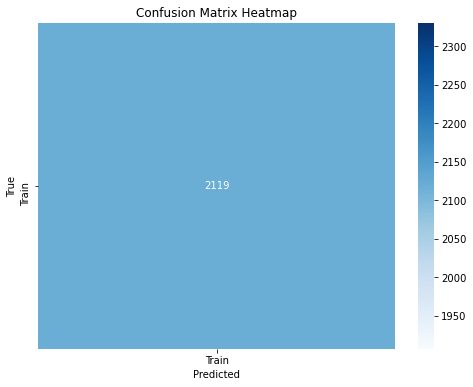

In [ ]:
import seaborn as sns

# Confusion matrix heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
# Single image inference helper
from PIL import Image
def predict_image(path):
    img = Image.open(path).convert('RGB')
    x = val_tf(img).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        out = model(x)
        pred = out.argmax(1).item()
    return train_ds.classes[pred]

# Example: pick a sample from test set (if available)
sample = None
for cls in train_ds.classes:
    p = (data_root/'test'/cls)
    if p.exists() and any(p.iterdir()):
        sample = next(p.glob('*'))
        break
if sample:
    print('Example sample:', sample)
    print('Predicted:', predict_image(sample))
else:
    print('No sample images found in test set.')


No sample images found in test set.
